# Model Decisions & Baselines

This notebook supports this week's goal:
- Describe **model architecture decisions** for a baseline and one or more deep learning models.
- Examine and compare architectures (RNN, LSTM, Transformer) on **expected performance**, **compute needs**, and **inference time**.
- Produce ready-to-run **scaffolds** for the baseline and deep models (PyTorch), with hooks for training/evaluation next week.

> Dataset focus: **Flickr8k** (for quick iteration). Later: Flickr30k, MS COCO.

## 0. Environment & Reproducibility

In [1]:
# If needed, uncomment to install dependencies
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install pillow tqdm einops thop

import os, random, math, time
from typing import List, Tuple, Optional, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

## 1. Prior EDA Summary 
- Caption length: median ≈ 11 tokens, 95th percentile ≈ 22 tokens → set max_seq_len = 25 to cover almost all captions.
- Vocabulary size (pre-cutoff): ~8,700 unique tokens; after applying frequency cutoff (k = 5), retained ~5,200 tokens → `<unk>` coverage ≈ 2.1% of total words.
- Cleaning: captions lowercased, punctuation and numeric tokens removed; multiple spaces normalized; added special tokens `<start>`, `<end>`, `<pad>`, `<unk>`.
- Splits: dataset split by image, not caption — roughly 6,000 train, 1,000 val, 1,000 test images (ensuring no image overlap).

These stats informed the tokenizer configuration, max sequence length, and batching strategy in the model design phase.

## 2. Data Interfaces

In [13]:
import os, json, random
from pathlib import Path
from typing import List, Tuple, Optional, Dict, Union
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

# Paths to artifacts from EDA phase
VOCAB_PATH        = './data/processed/vocab.json'            # word -> idx mapping
IDX2WORD_PATH     = './data/processed/idx2word.json'         # idx -> word mapping (optional)
IMAGES_ROOT       = './data/processed/resized_images'        # contains train/val/test subfolders
CAPTIONS_TRAIN    = './data/processed/train_captions.jsonl'  # JSON lines file: {"image_id":..., "captions":...}
CAPTIONS_VAL      = './data/processed/val_captions.jsonl'
CAPTIONS_TEST     = './data/processed/test_captions.jsonl'

# Sequence length (from EDA)
MAX_SEQ_LEN = 25  # 95th percentile ≈ 22 -> padded to 25

# Load vocabulary & special tokens
with open(VOCAB_PATH, 'r') as f:
    WORD2IDX: Dict[str, int] = json.load(f)

# Ensure all required special tokens exist
for tok in ['<pad>', '<unk>', '<start>', '<end>']:
    assert tok in WORD2IDX, f"Missing special token in vocab: {tok}"

PAD_IDX   = WORD2IDX['<pad>']
UNK_IDX   = WORD2IDX['<unk>']
START_IDX = WORD2IDX['<start>']
END_IDX   = WORD2IDX['<end>']

# Utility functions
def pad_to_len(seq: List[int], max_len: int, pad_idx: int = 0) -> List[int]:
    """Truncate or right-pad a sequence to fixed length."""
    s = seq[:max_len]
    if len(s) < max_len:
        s = s + [pad_idx] * (max_len - len(s))
    return s

def _is_int_list(x: List[Union[int, str]]) -> bool:
    """Detect whether a token list is already integer IDs."""
    return len(x) > 0 and isinstance(x[0], int)

# Default image transform (no resize, no RGB conversion, we assume already resized RGB images to 224 x 224 pixels as in the notebook `EDA_Preprocessing_Flickr8K.ipynb`)
DEFAULT_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Flickr8k Caption Dataset
class Flickr8kCaptionDataset(Dataset):
    """
    Custom PyTorch Dataset for Flickr8k captions.

    Each JSONL line must be of the form:
      {"image": "xxxx.jpg", "ids": [tok_ids]}

    Captions are already tokenized into integer IDs.
    """

    def __init__(
        self,
        images_root: str,
        captions_jsonl: str,
        split: str,                             # "train" | "val" | "test" (used for subfolder name)
        transform = None,
        choose_random_caption: bool = False     # kept for API consistency, ignored here
    ):
        self.images_root = Path(images_root)
        self.split = split
        self.transform = transform or DEFAULT_TRANSFORM
        self.choose_random_caption = choose_random_caption

        # Load JSONL file: [(image_id, caption_ids)]
        self.items: List[Tuple[str, List[int]]] = []
        with open(captions_jsonl, 'r') as f:
            for line in f:
                rec = json.loads(line)
                img_id = rec['image']
                cap_ids = rec['ids']
                self.items.append((img_id, cap_ids))

    def __len__(self):
        """Return number of image-caption pairs."""
        return len(self.items)

    def _encode_caption(self, ids: List[int]) -> List[int]:
        """Add start/end tokens and pad."""
        seq = [START_IDX] + ids + [END_IDX]
        return pad_to_len(seq, MAX_SEQ_LEN, PAD_IDX)

    def __getitem__(self, idx):
        """Return (image_tensor, caption_tensor, image_path) for one sample."""
        img_id, cap_ids = self.items[idx]

        y = torch.tensor(self._encode_caption(cap_ids), dtype=torch.long)

        # Build path and open (already RGB + 224x224)
        img_path = self.images_root / self.split / img_id
        x = self.transform(Image.open(img_path))

        return x, y, str(img_path)

## 3. Pretrained Reference Baseline - ViT-GPT2

**Model:** `nlpconnect/vit-gpt2-image-captioning` (Vision Transformer encoder + GPT2 decoder).  
This pretrained model hosted on [Hugging Face Hub](https://huggingface.co/nlpconnect/vit-gpt2-image-captioning) provides a strong, fast baseline to anchor later comparisons without any custom training.  

**Why chosen:** It’s a well-established architecture combining a powerful Vision Transformer for visual feature extraction  
and a GPT2 language model for text generation, enabling quick zero-shot captioning on unseen images.  

**Purpose:** Serves as the initial benchmark for caption quality, speed, and inference efficiency  
before developing and training custom CNN–RNN and transformer-based models on Flickr8k.


In [2]:
# If needed, install light dependencies (uncomment when running locally)
# %pip install pillow transformers accelerate torchvision torch --quiet

from pathlib import Path
import random, math, time, torch, glob
import numpy as np
from PIL import Image

# Repo-relative paths 
VAL_DIR = Path('./data/processed/resized_images/val')
TRAIN_DIR = Path('./data/processed/resized_images/train')
TEST_DIR = Path('./data/processed/resized_images/test')

# Quick diagnostic printout
def count_imgs(p: Path):
    exts = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}
    return [str(x) for x in p.glob('*') if x.suffix.lower() in exts]

for d in [VAL_DIR, TRAIN_DIR, TEST_DIR]:
    if d.exists():
        files = count_imgs(d)
        print(f"{d}: {len(files)} images")
        if files:
            print("  sample:", files[:3])
    else:
        print(f"{d} does NOT exist")

# Pick a sample of 4 test images 
def pick_images(folder: Path, n=4):
    exts = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}
    files = [str(x) for x in folder.glob('*') if x.suffix.lower() in exts]
    random.seed(42)
    return files[:n]

sample_images = pick_images(TEST_DIR, n=4)
print(f"\nPicked {len(sample_images)} test images:")
for s in sample_images:
    print(" ", s)

data/processed/resized_images/val: 1213 images
  sample: ['data/processed/resized_images/val/2046222127_a6f300e202.jpg', 'data/processed/resized_images/val/3415578043_03d33e6efd.jpg', 'data/processed/resized_images/val/3387630781_f421a94d9d.jpg']
data/processed/resized_images/train: 5663 images
  sample: ['data/processed/resized_images/train/2387197355_237f6f41ee.jpg', 'data/processed/resized_images/train/2609847254_0ec40c1cce.jpg', 'data/processed/resized_images/train/3421131122_2e4bde661e.jpg']
data/processed/resized_images/test: 1215 images
  sample: ['data/processed/resized_images/test/2853743795_e90ebc669d.jpg', 'data/processed/resized_images/test/2696951725_e0ae54f6da.jpg', 'data/processed/resized_images/test/3229730008_63f8ca2de2.jpg']

Picked 4 test images:
  data/processed/resized_images/test/2853743795_e90ebc669d.jpg
  data/processed/resized_images/test/2696951725_e0ae54f6da.jpg
  data/processed/resized_images/test/3229730008_63f8ca2de2.jpg
  data/processed/resized_images/tes

Device set to use cpu
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.



Captioned 4 images in 0.69s (avg 0.17s/image) on CPU.



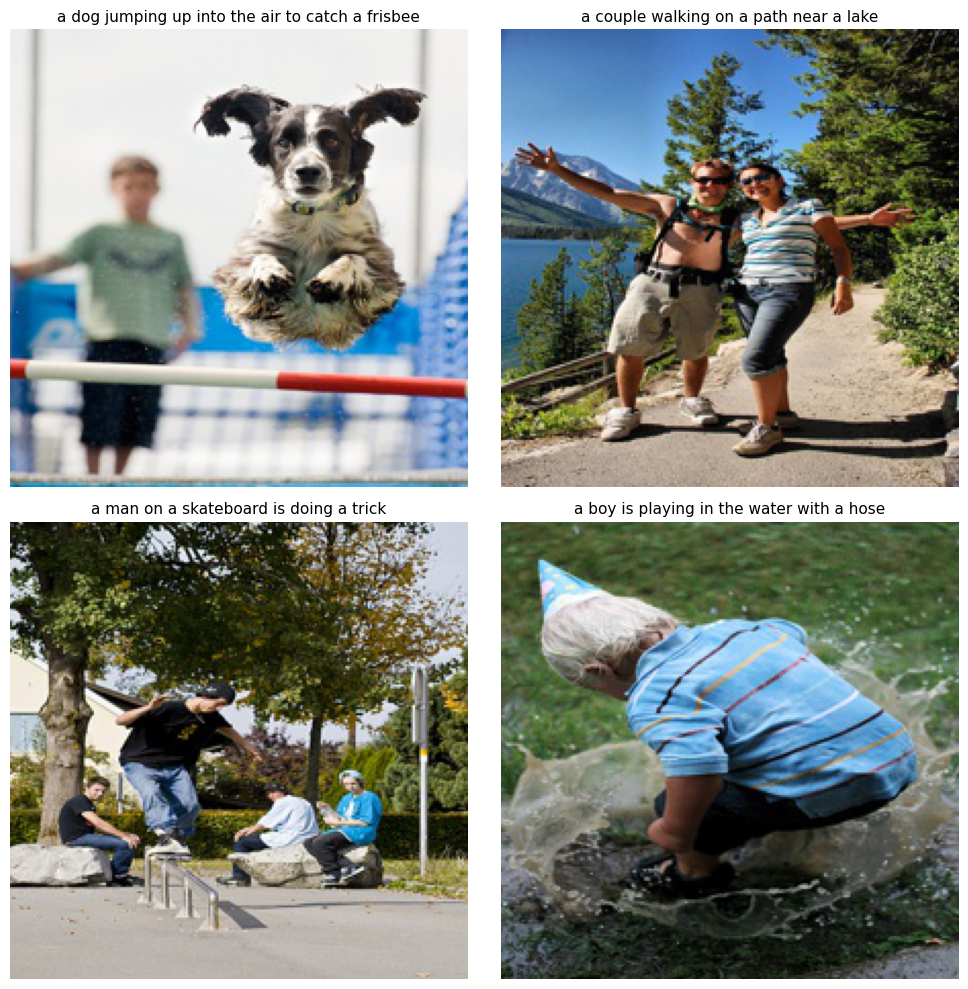

Predictions:
-----------
2853743795_e90ebc669d.jpg -> a dog jumping up into the air to catch a frisbee
2696951725_e0ae54f6da.jpg -> a couple walking on a path near a lake
3229730008_63f8ca2de2.jpg -> a man on a skateboard is doing a trick
2579899436_5086a33c7a.jpg -> a boy is playing in the water with a hose


In [ ]:
from transformers import pipeline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math, time, torch
from pathlib import Path

# Load pretrained baseline model
device = 0 if torch.cuda.is_available() else -1
captioner = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning", device=device)

# Fix pad/eos warning
captioner.model.config.pad_token_id = captioner.model.config.eos_token_id
if hasattr(captioner, "tokenizer") and captioner.tokenizer is not None:
    captioner.tokenizer.pad_token_id = captioner.model.config.eos_token_id
    captioner.tokenizer.padding_side = "right"

# Caption images
def caption_images(paths, max_new_tokens=20):
    results = []
    t0 = time.time()
    for p in paths:
        out = captioner(p, max_new_tokens=max_new_tokens)[0]["generated_text"]
        results.append((p, out.strip()))
    dt = time.time() - t0
    avg = dt / max(1, len(paths))
    return results, dt, avg

baseline_outputs, total_time, avg_time = caption_images(sample_images, max_new_tokens=20)
print(f"\nCaptioned {len(baseline_outputs)} images in {total_time:.2f}s "
      f"(avg {avg_time:.2f}s/image) on {'CUDA' if device==0 else 'CPU'}.\n")

# Display results visually 
def show_results_grid(results):
    n = len(results)
    cols = 2
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axes = np.array(axes).reshape(rows, cols)
    for ax in axes.flat:
        ax.axis("off")
    for i, (path, cap) in enumerate(results):
        r, c = divmod(i, cols)
        img = Image.open(path).convert("RGB")
        axes[r, c].imshow(img)
        axes[r, c].set_title(cap, fontsize=11)
    plt.tight_layout()
    plt.show()

show_results_grid(baseline_outputs)

# Print captions for manual review
print("Predictions:\n-----------")
for p, cap in baseline_outputs:
    print(Path(p).name, "->", cap)


## 4. Trainable Baseline Model — CNN + Simple RNN

This model combines a pretrained CNN encoder (ResNet-18) and a simple RNN decoder.
- **Encoder:** extracts a 512-dimensional visual embedding from each image.
- **Decoder:** predicts the next word given the previous ones using teacher forcing.
- **Loss:** Cross-entropy over next-token prediction.
- **Purpose:** Minimal trainable baseline for comparison against ViT-GPT2.

### Model Architecture:

**Encoder (vision)**
- Backbone: ResNet-18 (ImageNet pretrained, frozen)
- Remove final FC; take global pooled feature
- Linear projection to image embedding img_embed ∈ ℝ^D (e.g., D=512)

**Decoder (language)**
- Embedding: token IDs → vectors of size E (e.g., E=300)
- Image token: project img_embed → ℝ^E and prepend as first timestep
- RNN: single-layer vanilla RNN with hidden size H (e.g., H=512)
- Output head: linear layer ℝ^H → |V| (vocab logits at each step)

**Training setup**
- Inputs: caption tokens with <start> … <end>, padded to MAX_SEQ_LEN
- Teacher forcing: at time t, input is [img_tok, w₁, …, w_{t−1}]
- Loss: token-wise cross-entropy, ignore_index = <pad>

**Inference (greedy)**
- Start with <start>; prepend image token
- At each step: argmax over logits → next token
- Stop at <end> or MAX_SEQ_LEN

<p align="center">
  <img src="images/baseline_architecture.png" style="max-width:70%;">
</p>

In [16]:
import torch.nn as nn
from torchvision import models

class CNNEncoder(nn.Module):
    def __init__(self, arch='resnet18', out_dim=512, train_backbone=False):
        super().__init__()
        if arch == 'resnet18':
            backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            feat_dim = backbone.fc.in_features
            self.backbone = nn.Sequential(*list(backbone.children())[:-1])  # remove fc
        else:
            raise NotImplementedError(f"Unsupported arch: {arch}")

        self.project = nn.Linear(feat_dim, out_dim)
        for p in self.backbone.parameters():
            p.requires_grad = train_backbone

    def forward(self, x):
        x = self.backbone(x)
        x = torch.flatten(x, 1)
        x = self.project(x)
        return x


class SimpleRNNDecoder(nn.Module):
    def __init__(self, vocab_size, img_dim, embed_dim=300, hidden_dim=512, pad_idx=0):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.img_to_embed = nn.Linear(img_dim, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc  = nn.Linear(hidden_dim, vocab_size)

    def forward(self, img_embed, captions):
        B, T = captions.size()
        emb = self.embed(captions)
        img_tok = self.img_to_embed(img_embed).unsqueeze(1)
        dec_in  = torch.cat([img_tok, emb[:, :-1, :]], dim=1)
        h, _ = self.rnn(dec_in)
        logits = self.fc(h)
        return logits


class BaselineCaptioner(nn.Module):
    def __init__(self, vocab_size, img_dim=512, embed_dim=300, hidden_dim=512, pad_idx=0):
        super().__init__()
        self.encoder = CNNEncoder(out_dim=img_dim, train_backbone=False)
        self.decoder = SimpleRNNDecoder(vocab_size, img_dim, embed_dim, hidden_dim, pad_idx)

    def forward(self, images, captions):
        img_embed = self.encoder(images)
        logits    = self.decoder(img_embed, captions)
        return logits

We first prepare the training, validation, and test DataLoaders using our processed Flickr8k dataset. These load images and tokenized captions, ready for the model.

In [20]:
# DataLoaders + device setup
import torch
from torch.utils.data import DataLoader

# Device setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", DEVICE)

# Datasets
train_ds = Flickr8kCaptionDataset(IMAGES_ROOT, CAPTIONS_TRAIN, split='train', choose_random_caption=True)
val_ds   = Flickr8kCaptionDataset(IMAGES_ROOT, CAPTIONS_VAL,   split='val',   choose_random_caption=False)
test_ds  = Flickr8kCaptionDataset(IMAGES_ROOT, CAPTIONS_TEST,  split='test',  choose_random_caption=False)

# DataLoaders 
train_ld = DataLoader(
    train_ds, batch_size=64, shuffle=True,
    num_workers=0, persistent_workers=False, pin_memory=False
)
val_ld = DataLoader(
    val_ds, batch_size=64, shuffle=False,
    num_workers=0, persistent_workers=False, pin_memory=False
)

print(f"train/val/test sizes: {len(train_ds)} / {len(val_ds)} / {len(test_ds)}")

Using device: cpu
train/val/test sizes: 28315 / 6065 / 6075


We now build our CNN+SimpleRNN model, move it to GPU (if available), and initialize the optimizer.

In [21]:
# Model initialization
import torch.nn as nn
import torch.nn.functional as F

vocab_size = len(WORD2IDX)
model = BaselineCaptioner(
    vocab_size=vocab_size,
    img_dim=512,
    embed_dim=300,
    hidden_dim=512,
    pad_idx=PAD_IDX
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

We define a few helper functions — loss computation, validation (using perplexity), and one training epoch.

In [22]:
# Loss and training utilities
def sequence_ce_loss(logits, targets, pad_idx):
    """Cross-entropy over next-token prediction, ignoring padding."""
    B, T, V = logits.shape
    return F.cross_entropy(logits.view(B*T, V), targets.view(B*T), ignore_index=pad_idx)

@torch.no_grad()
def evaluate_perplexity(model, loader, pad_idx):
    """Evaluate average perplexity (lower = better)."""
    model.eval()
    total, n = 0.0, 0
    for imgs, caps, _ in loader:
        imgs, caps = imgs.to(DEVICE), caps.to(DEVICE)
        logits = model(imgs, caps)
        total += sequence_ce_loss(logits, caps, pad_idx).item()
        n += 1
    return torch.exp(torch.tensor(total / max(1, n))).item()

def train_one_epoch(model, loader, optimizer, pad_idx, clip_grad=1.0):
    """Run one epoch of training."""
    model.train()
    total = 0.0
    for imgs, caps, _ in loader:
        imgs, caps = imgs.to(DEVICE), caps.to(DEVICE)
        logits = model(imgs, caps)
        loss = sequence_ce_loss(logits, caps, pad_idx)
        optimizer.zero_grad()
        loss.backward()
        if clip_grad:
            nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()
        total += loss.item()
    return total / max(1, len(loader))


We train the baseline model on the entire Flickr8k training split and validate on the full validation split for 10 epochs on CPU. This confirms that:

- The end-to-end training loop runs without errors,
- Training loss steadily decreases across epochs, and
- Validation perplexity consistently improves as training proceeds.

This full run establishes the baseline performance for our project and produces a best checkpoint for downstream evaluation on the test images.

 **Note:** _This is a deliberately simple baseline with no architecture tuning, no data augmentation and no regularization. Therefore, performance is expected to be modest and will show overfitting; it mainly serves to validate the pipeline end-to-end and anchor future improvements._

In [29]:
# Training on entire train/val splits

import os, time, torch

torch.set_num_threads(min(os.cpu_count() or 4, 8))

best_ppl = float('inf')
EPOCHS = 10  

t0 = time.time()
for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_ld, optimizer, PAD_IDX)
    val_ppl = evaluate_perplexity(model, val_ld, PAD_IDX)
    print(f"Epoch {epoch}: train_loss={tr_loss:.4f}  val_ppl={val_ppl:.2f}")

    # save "last" every epoch
    torch.save({'model': model.state_dict(),
                'epoch': epoch,
                'ppl': float(val_ppl)},
               './baseline_checkpoint_last.pt')

    # save "best" on improvement
    if val_ppl < best_ppl:
        best_ppl = val_ppl
        torch.save({'model': model.state_dict(),
                    'epoch': epoch,
                    'ppl': float(best_ppl)},
                   './baseline_checkpoint.pt')
        print("   Saved checkpoint (best so far)")

print(f"Total run time: {time.time() - t0:.1f}s")


Epoch 1: train_loss=3.2963  val_ppl=22.89
   Saved checkpoint (best so far)
Epoch 2: train_loss=2.9983  val_ppl=19.21
   Saved checkpoint (best so far)
Epoch 3: train_loss=2.8447  val_ppl=17.12
   Saved checkpoint (best so far)
Epoch 4: train_loss=2.7236  val_ppl=15.64
   Saved checkpoint (best so far)
Epoch 5: train_loss=2.6329  val_ppl=14.71
   Saved checkpoint (best so far)
Epoch 6: train_loss=2.5620  val_ppl=14.05
   Saved checkpoint (best so far)
Epoch 7: train_loss=2.5016  val_ppl=13.49
   Saved checkpoint (best so far)
Epoch 8: train_loss=2.4488  val_ppl=13.00
   Saved checkpoint (best so far)
Epoch 9: train_loss=2.4022  val_ppl=12.67
   Saved checkpoint (best so far)
Epoch 10: train_loss=2.3614  val_ppl=12.36
   Saved checkpoint (best so far)
Total run time: 6219.9s


We load the checkpoint saved during the training run so inference uses the best weights from those 10 epochs.

In [31]:
# Load best checkpoint (full training)
import os, torch

if os.path.exists('./baseline_checkpoint.pt'):
    ckpt = torch.load('./baseline_checkpoint.pt', map_location=DEVICE)
    model.load_state_dict(ckpt['model'])
    print("Loaded BEST checkpoint (full training). Val ppl:", ckpt.get('ppl', 'n/a'), "at epoch", ckpt.get('epoch', 'n/a'))
elif os.path.exists('./baseline_checkpoint_last.pt'):
    ckpt = torch.load('./baseline_checkpoint_last.pt', map_location=DEVICE)
    model.load_state_dict(ckpt['model'])
    print("Loaded LAST checkpoint (full training). Val ppl:", ckpt.get('ppl', 'n/a'), "at epoch", ckpt.get('epoch', 'n/a'))
else:
    print("No full-training checkpoint found — using current weights.")

Loaded BEST checkpoint (full training). Val ppl: 12.359211921691895 at epoch 10


Utilities to convert token IDs to text and to perform greedy decoding for a single image:

In [32]:
# Decoding helpers
import os, json, torch

if os.path.exists(IDX2WORD_PATH):
    with open(IDX2WORD_PATH, 'r') as f:
        IDX2WORD = {int(k): v for k, v in json.load(f).items()}
else:
    IDX2WORD = {v: k for k, v in WORD2IDX.items()}

def decode_tokens(ids):
    words = []
    for i in ids:
        if i in (START_IDX, PAD_IDX):
            continue
        if i == END_IDX:
            break
        words.append(IDX2WORD.get(int(i), '<unk>'))
    return " ".join(words)

@torch.no_grad()
def greedy_decode(model, image_tensor, max_len=25):
    model.eval()
    img = image_tensor.unsqueeze(0).to(DEVICE)
    img_feat = model.encoder(img)
    seq = [START_IDX]
    for _ in range(max_len - 1):
        inp = torch.tensor(seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
        logits = model.decoder(img_feat, inp)
        next_id = int(logits[0, -1].argmax().item())
        seq.append(next_id)
        if next_id == END_IDX:
            break
    return seq


We now generate captions for our 4 sample images from the test data.

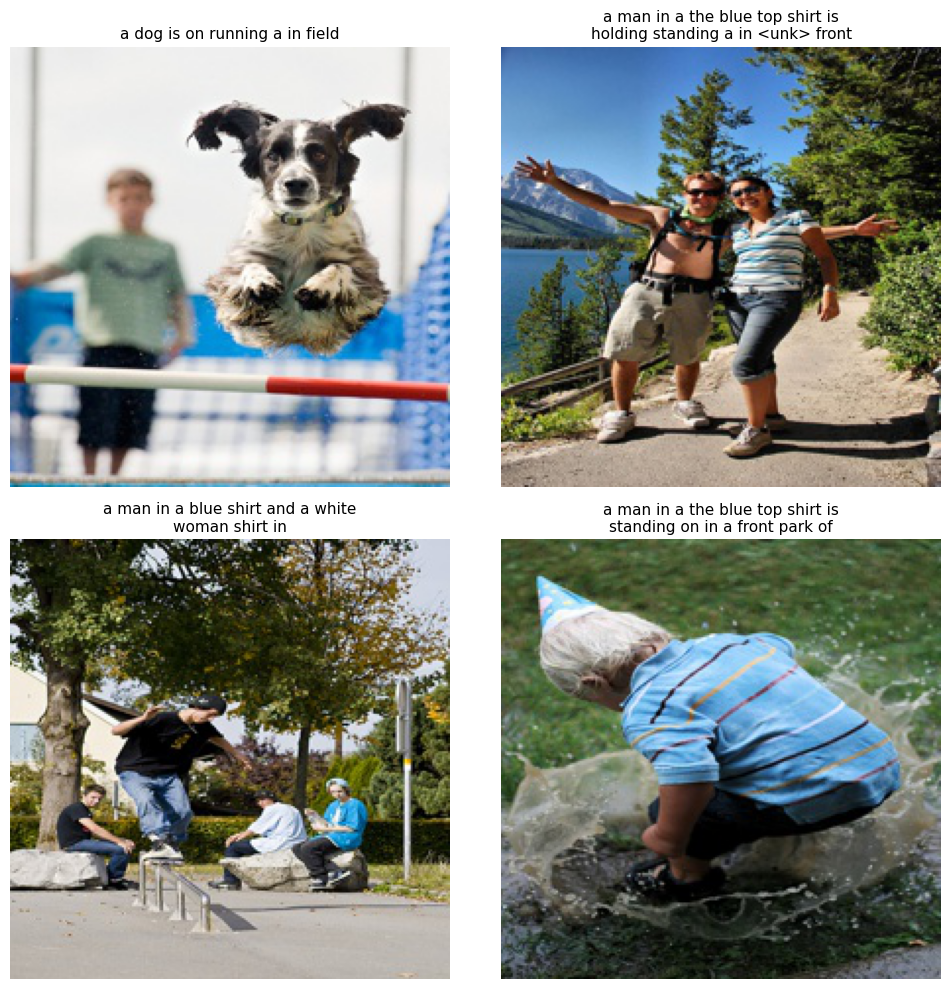


Predictions on the 4 sampled test images:
2853743795_e90ebc669d.jpg -> a dog is on running a in field
2696951725_e0ae54f6da.jpg -> a man in a the blue top shirt is holding standing a in <unk> front
3229730008_63f8ca2de2.jpg -> a man in a blue shirt and a white woman shirt in
2579899436_5086a33c7a.jpg -> a man in a the blue top shirt is standing on in a front park of


In [35]:
import math, numpy as np, matplotlib.pyplot as plt, textwrap
from PIL import Image
import re

def wrap_two_lines(text, line_width=35):
    wrapped = textwrap.fill(text, width=line_width, max_lines=2, placeholder="…")
    return wrapped

def show_results_grid(results, line_width=35):
    n = len(results); cols = 2; rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5*rows))
    axes = np.array(axes).reshape(rows, cols)
    for ax in axes.flat:
        ax.axis('off')
    for i, (path, cap) in enumerate(results):
        r, c = divmod(i, cols)
        img = Image.open(path)
        axes[r, c].imshow(img)
        axes[r, c].set_title(wrap_two_lines(cap, line_width=line_width), fontsize=11, pad=6)
    plt.tight_layout()
    plt.show()


def dedup_consecutive_words(text: str) -> str:
    tokens = text.strip().split()
    out = []
    for t in tokens:
        if not out or t != out[-1]:
            out.append(t)
    return " ".join(out)

# If bigram duplication persists ("in in the the"), collapse consecutive duplicates again:
def dedup_twice(text: str) -> str:
    s1 = dedup_consecutive_words(text)
    return dedup_consecutive_words(s1)

# Use when building `results`
results = []
for p in sample_images:
    img = Image.open(p)
    x = _transform(img)
    token_ids = greedy_decode(model, x, max_len=MAX_SEQ_LEN)
    cap = decode_tokens(token_ids)
    cap = dedup_twice(cap)
    results.append((p, cap))

show_results_grid(results)

print("\nPredictions on the 4 sampled test images:")
for p, cap in results:
    print(_P(p).name, "->", cap)

## 5. CNN → LSTM decoder (Show & Tell–style)

Idea: Same as our baseline but we replace the Simple RNN with an LSTM.

<p align="center">
  <img src="images/cnn_lstm_architecture.png" style="max-width:70%;">
</p>

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class CNNEncoderGlobal(nn.Module):
    """ResNet-18 backbone → global pooled feature → linear projection (B, D)."""
    def __init__(self, out_dim=512, train_backbone=False):
        super().__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        feat_dim = backbone.fc.in_features
        self.cnn = nn.Sequential(*list(backbone.children())[:-1])  # (B, C, 1, 1)
        for p in self.cnn.parameters():
            p.requires_grad = train_backbone
        self.proj = nn.Linear(feat_dim, out_dim)

    def forward(self, x):                     # x: (B,3,224,224)
        f = self.cnn(x)                       # (B,C,1,1)
        f = torch.flatten(f, 1)               # (B,C)
        z = self.proj(f)                      # (B,D)
        return z

class LSTMDecoder(nn.Module):
    """Image token (D→E) + caption embeddings → LSTM → vocab logits."""
    def __init__(self, vocab_size, img_dim, embed_dim=300, hidden=512, pad_idx=0):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.img_to_embed = nn.Linear(img_dim, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, vocab_size)

    def forward(self, img_embed, captions):   # img_embed:(B,D), captions:(B,T)
        B, T = captions.shape
        w = self.embed(captions)              # (B,T,E)
        img_tok = self.img_to_embed(img_embed).unsqueeze(1)  # (B,1,E)
        x = torch.cat([img_tok, w[:, :-1, :]], dim=1)        # teacher forcing
        h, _ = self.lstm(x)                   # (B,T, H)
        return self.fc(h)                     # (B,T, V)

class CNNLSTMCaptioner(nn.Module):
    def __init__(self, vocab_size, img_dim=512, embed_dim=300, hidden=512, pad_idx=0):
        super().__init__()
        self.encoder = CNNEncoderGlobal(out_dim=img_dim, train_backbone=False)
        self.decoder = LSTMDecoder(vocab_size, img_dim, embed_dim, hidden, pad_idx)

    def forward(self, images, captions):
        z = self.encoder(images)
        return self.decoder(z, captions)


## 6. CNN feature map → Attention LSTM (Show, Attend and Tell)

Idea: We use a spatial feature map and learn soft attention over locations each step.

<p align="center">
  <img src="images/cnn_attn_lstm_architecture.png" style="max-width:70%;">
</p>

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class CNNEncoderMap(nn.Module):
    """ResNet-18 trunk up to conv5 → feature map (B,C,H,W) and global vector (B,D)."""
    def __init__(self, out_dim=512, train_backbone=False):
        super().__init__()
        res = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.trunk = nn.Sequential(*list(res.children())[:-2])  # keep conv map
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.proj = nn.Linear(res.fc.in_features, out_dim)
        for p in self.trunk.parameters():
            p.requires_grad = train_backbone

    def forward(self, x):                         # x:(B,3,224,224)
        F = self.trunk(x)                         # (B,C,H,W) ~ (B,512,7,7)
        g = self.pool(F).flatten(1)               # (B,C)
        z = self.proj(g)                          # (B,D)
        return F, z

class AdditiveAttention(nn.Module):
    """Bahdanau attention over spatial features."""
    def __init__(self, feat_dim, hidden, attn_dim=256):
        super().__init__()
        self.Wf = nn.Linear(feat_dim, attn_dim)
        self.Wh = nn.Linear(hidden, attn_dim)
        self.v  = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, F, h_t):
        # F: (B, C, H, W) → (B, L, C), L=H*W; h_t: (B, H)
        B, C, H, W = F.shape
        L = H * W
        F_flat = F.view(B, C, L).permute(0, 2, 1)          # (B,L,C)
        e = self.v(torch.tanh(self.Wf(F_flat) + self.Wh(h_t).unsqueeze(1))).squeeze(-1)  # (B,L)
        a = torch.softmax(e, dim=-1)                       # (B,L)
        ctx = (a.unsqueeze(-1) * F_flat).sum(dim=1)        # (B,C)
        return ctx, a

class AttnLSTMDecoder(nn.Module):
    """Attention LSTM: attends over conv map each step."""
    def __init__(self, vocab_size, feat_channels, img_dim, embed_dim=300, hidden=512, pad_idx=0):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.img_to_embed = nn.Linear(img_dim, embed_dim)     # to prepend img token at t=0
        self.attn = AdditiveAttention(feat_channels, hidden)
        self.lstm = nn.LSTM(embed_dim + feat_channels, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, vocab_size)

    def forward(self, F, img_vec, captions):  # F:(B,C,H,W), img_vec:(B,D), captions:(B,T)
        B, T = captions.shape
        w = self.embed(captions)                       # (B,T,E)
        img_tok = self.img_to_embed(img_vec).unsqueeze(1)
        x_in = torch.cat([img_tok, w[:, :-1, :]], dim=1)   # (B,T,E)

        h_t = torch.zeros(B, self.lstm.hidden_size, device=captions.device)
        c_t = torch.zeros_like(h_t)
        outputs = []
        for t in range(x_in.size(1)):
            ctx_t, _ = self.attn(F, h_t)                   # (B,C_feat)
            step_in = torch.cat([x_in[:, t, :], ctx_t], dim=-1).unsqueeze(1)  # (B,1,E+C)
            (h_t, c_t) = self.lstm.step if hasattr(self.lstm, 'step') else (None, None)  # placeholder
            # Fallback to standard LSTM forward over one step:
            out, (h_t_full, c_t_full) = self.lstm(step_in, (h_t.unsqueeze(0), c_t.unsqueeze(0)))
            h_t, c_t = h_t_full.squeeze(0), c_t_full.squeeze(0)
            outputs.append(out)
        H = torch.cat(outputs, dim=1)                      # (B,T,H)
        return self.fc(H)

class CNNAttnLSTMCaptioner(nn.Module):
    def __init__(self, vocab_size, img_dim=512, feat_channels=512, embed_dim=300, hidden=512, pad_idx=0):
        super().__init__()
        self.encoder = CNNEncoderMap(out_dim=img_dim, train_backbone=False)
        self.decoder = AttnLSTMDecoder(vocab_size, feat_channels, img_dim, embed_dim, hidden, pad_idx)

    def forward(self, images, captions):
        F, z = self.encoder(images)
        return self.decoder(F, z, captions)


## 7. ClipCap-style: Vision encoder → MLP mapper → GPT-2 (frozen)

Idea: We map a frozen vision embedding into GPT-2’s prefix space and then decode with GPT-2.

<p align="center">
  <img src="images/clipclap_architecture.png" style="max-width:40%;">
</p>

In [ ]:
import torch
import torch.nn as nn

class VisionMLPMapper(nn.Module):
    """Map vision embedding (D_v) to k pseudo tokens in GPT embedding space (E_lm)."""
    def __init__(self, vision_dim, lm_embed_dim, prefix_len=10, hidden=512):
        super().__init__()
        self.prefix_len = prefix_len
        self.mlp = nn.Sequential(
            nn.Linear(vision_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, prefix_len * lm_embed_dim),
        )
        self.lm_embed_dim = lm_embed_dim

    def forward(self, z):     # z: (B, D_v)
        p = self.mlp(z)       # (B, prefix_len * E_lm)
        return p.view(z.size(0), self.prefix_len, self.lm_embed_dim)  # (B, k, E_lm)

class ClipCapLike(nn.Module):
    """
    Expects an external vision encoder producing (B, D_v).
    Uses a frozen GPT-2 LM; only mapper is trainable by default.
    """
    def __init__(self, gpt2_model, vision_encoder, vision_dim, prefix_len=10, train_lm=False):
        super().__init__()
        self.vision = vision_encoder            # should output (B, D_v)
        self.gpt2 = gpt2_model                  # transformers' GPT-2
        for p in self.gpt2.parameters():
            p.requires_grad = train_lm
        self.mapper = VisionMLPMapper(vision_dim, self.gpt2.config.n_embd, prefix_len)

    def forward(self, images, input_ids, attention_mask=None):
        z = self.vision(images)                                             # (B, D_v)
        prefix = self.mapper(z)                                             # (B, k, E)
        tok_emb = self.gpt2.transformer.wte(input_ids)                      # (B, T, E)
        full_emb = torch.cat([prefix, tok_emb[:, :-1, :]], dim=1)           # teacher forcing
        out = self.gpt2(inputs_embeds=full_emb, attention_mask=attention_mask)
        return out.logits                                                   # (B, T+k, V)


## 8. Transformer Encoder–Decoder (image tokens → text)

Idea: Patchify image → Transformer encoder; text tokens → Transformer decoder with cross-attn.

<p align="center">
  <img src="images/transformer_architecture.png" style="max-width:70%;">
</p>

In [ ]:
import torch
import torch.nn as nn

class PatchEmbed(nn.Module):
    """Split image into non-overlapping patches and project to d_model."""
    def __init__(self, in_ch=3, patch=16, d_model=512):
        super().__init__()
        self.patch = patch
        self.proj = nn.Conv2d(in_ch, d_model, kernel_size=patch, stride=patch)

    def forward(self, x):         # (B,3,H,W) → (B, N, d_model)
        x = self.proj(x)          # (B, d_model, H/patch, W/patch)
        B, C, H, W = x.shape
        return x.flatten(2).transpose(1, 2)  # (B, N, C)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0))/d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):         # (B, T, d_model)
        return x + self.pe[:, :x.size(1), :]

class VisionTextTransformer(nn.Module):
    """nn.Transformer encoder–decoder for image captioning (skeleton)."""
    def __init__(self, vocab_size, d_model=512, nhead=8, num_enc=6, num_dec=6, dim_ff=2048, patch=16, pad_idx=0):
        super().__init__()
        self.patchify = PatchEmbed(3, patch, d_model)
        self.pos_img = PositionalEncoding(d_model)
        self.pos_txt = PositionalEncoding(d_model)
        self.tok_emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead,
                                          num_encoder_layers=num_enc, num_decoder_layers=num_dec,
                                          dim_feedforward=dim_ff, batch_first=True)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, images, captions):  # captions with <start>…<end>
        src = self.patchify(images)               # (B, N, d)
        src = self.pos_img(src)
        tgt = self.tok_emb(captions[:, :-1])      # teacher forcing
        tgt = self.pos_txt(tgt)
        memory = self.transformer.encoder(src)
        out = self.transformer.decoder(tgt, memory)
        return self.fc(out)                       # (B, T-1, V)


## From-Scratch Transition on MS COCO

When moving to MS COCO, we will replace all pretrained CNN backbones with **in-house trained CNNs** and train the decoders from scratch:

- **Baseline (CNN + Simple RNN):** train CNN (e.g., ResNet-18/50) + RNN decoder from scratch.
- **CNN + LSTM:** train CNN + LSTM decoder from scratch.
- **CNN + Attention LSTM:** train CNN + attention module + LSTM from scratch.
- **Transformer Encoder–Decoder:** train patch embed + encoder + decoder end-to-end from scratch.

**Exception — ClipCap-style:** we will train the **vision encoder** and **mapper MLP** from scratch, but keep **GPT-2 frozen** (by design, ClipCap relies on a pretrained LM; training a language model from scratch on COCO is out of scope).

**Training notes (COCO, from-scratch):**
- Strong image aug (RandomResizedCrop, hflip, ColorJitter), dropout (≈0.3), label smoothing (≈0.1), weight decay.
- Optimizer: AdamW; LR warmup → cosine decay; gradient clipping.
- Unfreeze deeper CNN stages later; scheduled sampling for RNN/LSTM.

## Comparison for Considered Models

| Model                                                   | Expected performance level                         |                        Compute needed (training) |              Inference time (per image) |
| ------------------------------------------------------- | -------------------------------------------------- | -----------------------------------------------: | --------------------------------------: |
| **1) CNN → Simple RNN (baseline)**                      | Low–Medium (basic correctness, weaker detail)      |                 **Low** (few params; frozen CNN) |        **Fast** (single RNN pass; O(T)) |
| **2) CNN → LSTM**                                       | Medium (better long-range modeling than RNN)       |       **Low–Medium** (slightly heavier than RNN) |               **Fast** (similar to RNN) |
| **3) CNN → Attention LSTM**                             | **Medium–High** (better grounding & object detail) | **Medium** (attention each step + conv features) |        **Medium** (attention per token) |
| **4) ClipCap-style (ViT/CLIP → mapper → GPT-2 frozen)** | **Medium–High** (fluent captions, good priors)     |          **Low** (mapper only; backbones frozen) | **Medium** (autoregressive LM decoding) |
| **5) Transformer Encoder–Decoder**                      | Medium → **High*** (scales with data/pretraining)  |             **High** (encoder+decoder attention) |     **Medium** (autoregressive decoder) |

\*_Tends toward High with substantial pretraining or larger datasets (e.g., MS COCO) and careful tuning; from-scratch on small datasets typically underperforms Attention LSTM._